 # MVPA LOSO BOLD Factors

In [1]:
import numpy as np
import nibabel as nb
import os

In [2]:
# define paths
root_dir = '/Volumes/T7/BIDS-BRAINPLAYBACK-TASK2'
fmriprep_dir = os.path.join(root_dir, 'derivatives', 'fmriprep23')
dataset_dir  = os.path.join(root_dir, 'derivatives', 'mvpa_05_factors_bold', 'features')

In [3]:
# list datasets and concatenate

# find all *_dataset.nii.gz files in dataset_dir
dataset_files = [os.path.join(dataset_dir, f) for f in os.listdir(dataset_dir) if f.endswith('_features.npy') & f.startswith('sub-')]
dataset_files.sort()

# find all *_trial_types.txt files in dataset_dir
label_files = [os.path.join(dataset_dir, f) for f in os.listdir(dataset_dir) if f.endswith('_labels.npy') & f.startswith('sub-')]
label_files.sort()

In [4]:
# get number of subjects
n_runs_per_sub = 4
n_subjects = len(dataset_files) / n_runs_per_sub
print('Number of subjects found: %f' % n_subjects)

Number of subjects found: 17.000000


In [5]:
# estimate expected number of rows
# 17 subjects, 9 x 2 music for each of the 4 runs

n_noise_trials = 0
n_noise_splits = 0
n_music_trials = 9*2
n_music_splits = 4

n_rows_estimate_per_sub = n_runs_per_sub * (n_noise_trials*n_noise_splits + n_music_trials*n_music_splits)
n_rows_estimate = n_subjects * n_rows_estimate_per_sub
print(f'Estimated number of rows: {n_rows_estimate}')

Estimated number of rows: 4896.0


In [6]:
# concatenate all datasets in dataset_files
print('Concatenating datasets...')
samples = np.concatenate([np.load(f) for f in dataset_files], axis=0)
print('Dataset shape: %s' % str(samples.shape))

Concatenating datasets...
Dataset shape: (4896, 2671)


In [7]:
# concatenate all labels into a single string array
print('Concatenating labels...')
labels = np.concatenate([np.load(f, allow_pickle=True) for f in label_files], axis=0)
print('Labels shape: %s' % str(labels.shape))

Concatenating labels...
Labels shape: (4896,)


In [8]:
s = np.sum(labels == 'Sublimity')
v = np.sum(labels == 'Vitality')
u = np.sum(labels == 'Unease')
print(s)
print(v)
print(u)

#n_samples / (n_classes * np.bincount(y))

2720
1088
1088


In [9]:
class_names = np.unique(labels)
n_classes = len(class_names)
print(f'Number of classes: {n_classes}')

Number of classes: 3


In [10]:
# generate an array of chunk labels
chunks = np.repeat(np.arange(1,n_subjects+1), n_rows_estimate_per_sub)

In [11]:
chunks.shape

(4896,)

## single test

In [32]:
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit

In [34]:
#from sklearn.svm import LinearSVC, SVC, GridSearchCV

# clf = LinearSVC(multi_class="ovr", max_iter=7500, 
#                 class_weight={'Sublimity':0.01, 'Vitality': 1, 'Unease':1},
#                 dual='auto', C=1)

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(class_weight='balanced'), param_grid=param_grid, cv=cv, n_jobs=6)

ff = 1
# split the data into training and test set
train_mask = chunks != ff+1
test_mask = chunks == ff+1

X_train = samples[train_mask, :]
y_train = labels[train_mask]
X_test = samples[test_mask, :]
y_test = labels[test_mask]

grid.fit(X_train, y_train)

y_pred = grid.best_estimator_.predict(X_test)


KeyboardInterrupt: 

In [ ]:
# save model


In [28]:
from sklearn.metrics import balanced_accuracy_score
acc_bal = balanced_accuracy_score(y_test, y_pred)
acc_bal

0.33958333333333335

In [29]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred, normalize=None)
cm

array([[98, 25, 37],
       [42, 12, 10],
       [36, 14, 14]])

In [32]:
clf.get_params()

{'C': 0.1,
 'class_weight': 'balanced',
 'dual': 'auto',
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 7500,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

## Manual Leave One Subject Out Cross Validation

In [35]:
from sklearn.metrics import balanced_accuracy_score
import numpy as np
from sklearn.svm import LinearSVC
from concurrent.futures import ThreadPoolExecutor
from sklearn.metrics import confusion_matrix

n_folds = int(n_subjects)
acc_array = np.zeros(n_folds)
acc_bal_array = np.zeros(n_folds)
confusion_matrix_array = np.zeros((n_classes,n_classes,n_folds))

def process_fold(ff):
    print(f'fold {ff+1}/{n_folds}...')

    clf = LinearSVC(multi_class="ovr", max_iter=7500, class_weight={'Sublimity':0.1, 'Vitality': 1, 'Unease':1}, dual='auto', C=1)
    
    # split the data into training and test set
    train_mask = chunks != ff+1
    test_mask = chunks == ff+1

    X_train = samples[train_mask, :]
    y_train = labels[train_mask]
    X_test = samples[test_mask, :]
    y_test = labels[test_mask]

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Compute the prediction accuracy for the different labels
    acc = (y_pred == y_test).mean()
    acc_bal = balanced_accuracy_score(y_test, y_pred)

    # confusion matrix
    cm = confusion_matrix(y_test, y_pred, normalize='true')

    return ff, acc, acc_bal, cm

with ThreadPoolExecutor(max_workers=6) as executor:
    results = list(executor.map(process_fold, range(n_folds)))

# Update the accuracy arrays with the results
for ff, acc, acc_bal, cm in results:
    acc_array[ff] = acc
    acc_bal_array[ff] = acc_bal
    confusion_matrix_array[...,ff] = cm

fold 1/17...
fold 2/17...
fold 3/17...
fold 4/17...
fold 5/17...
fold 6/17...


In [21]:
print(f"Mean accuracy: {acc_array.mean()*100:0.1f}% \u00B1 {acc_array.std()*100:0.1f}%")
print(f"Mean balanced accuracy: {acc_bal_array.mean()*100:0.1f}% \u00B1 {acc_bal_array.std()*100:0.1f}%")

Mean accuracy: 36.9% ± 3.0%
Mean balanced accuracy: 34.8% ± 2.5%


In [22]:
M = np.mean(confusion_matrix_array, 2)*100
M_annot = [f'{M[0,0]:0.1f}%', f'{M[0,1]:0.1f}%', f'{M[0,2]:0.1f}%',
           f'{M[1,0]:0.1f}%', f'{M[1,1]:0.1f}%', f'{M[1,2]:0.1f}%',
           f'{M[2,0]:0.1f}%', f'{M[2,1]:0.1f}%', f'{M[2,2]:0.1f}%']
M_annot_plot = np.array(M_annot).reshape(M.shape)

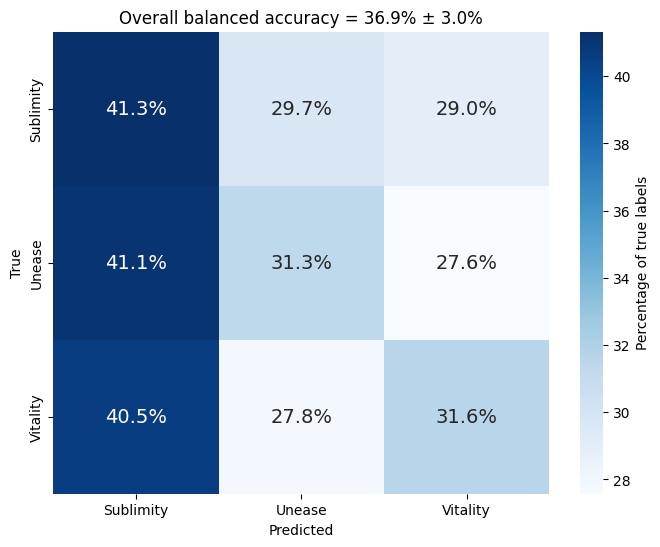

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(M, annot=M_annot_plot, fmt = '', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, 
            annot_kws={"size": 14},
            cbar_kws={'label': 'Percentage of true labels'})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Overall balanced accuracy = {acc_array.mean()*100:0.1f}% \u00B1 {acc_array.std()*100:0.1f}%')
plt.show()

## Dummy Classifier

In [28]:
from sklearn.dummy import DummyClassifier

acc_array_dummy = np.zeros(n_folds)
acc_bal_array_dummy = np.zeros(n_folds)
confusion_matrix_array_dummy = np.zeros((n_classes,n_classes,n_folds))

def process_fold_dummy(ff):
    print(f'fold {ff+1}/{n_folds}...')

    clf_dummy = DummyClassifier(strategy='prior')
    
    # split the data into training and test set
    train_mask = chunks != ff+1
    test_mask = chunks == ff+1

    X_train = samples[train_mask, :]
    y_train = labels[train_mask]
    X_test = samples[test_mask, :]
    y_test = labels[test_mask]

    clf_dummy.fit(X_train, y_train)
    y_pred = clf_dummy.predict(X_test)

    # Compute the prediction accuracy for the different labels
    acc = (y_pred == y_test).mean()
    acc_bal = balanced_accuracy_score(y_test, y_pred)

    # confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    return ff, acc, acc_bal, cm

with ThreadPoolExecutor(max_workers=6) as executor:
    results = list(executor.map(process_fold_dummy, range(n_folds)))

# Update the accuracy arrays with the results
for ff, acc, acc_bal, cm in results:
    acc_array_dummy[ff] = acc
    acc_bal_array_dummy[ff] = acc_bal
    confusion_matrix_array_dummy[...,ff] = cm

fold 1/17...fold 2/17...

fold 3/17...
fold 4/17...
fold 5/17...
fold 6/17...
fold 7/17...
fold 8/17...
fold 9/17...
fold 10/17...
fold 11/17...
fold 12/17...
fold 13/17...
fold 14/17...
fold 15/17...
fold 16/17...
fold 17/17...


In [29]:
print(f"Mean accuracy: {acc_array_dummy.mean()*100:0.1f}% \u00B1 {acc_array_dummy.std()*100:0.1f}%")
print(f"Mean balanced accuracy: {acc_bal_array_dummy.mean()*100:0.1f}% \u00B1 {acc_bal_array_dummy.std()*100:0.1f}%")

Mean accuracy: 55.6% ± 0.0%
Mean balanced accuracy: 33.3% ± 0.0%


## Test Linear SVC vs. Dummy

In [30]:
from scipy.stats import mannwhitneyu

# Perform Wilcoxon Signed-Rank Test
stat, p_value = mannwhitneyu(acc_bal_array, acc_bal_array_dummy)

print(f'Mann-Whitney U Test Statistic: {stat}')
print(f'P-value: {p_value}')

Mann-Whitney U Test Statistic: 212.5
P-value: 0.011765827200792207
